In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ctgan import CTGAN
from ctgan import load_demo
import data_describe as dd
import warnings
warnings.filterwarnings("ignore")

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures

In [2]:
data = pd.read_csv('../data/S&P 500 Real Estate 100-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data

,date,S&P 500,S&P 500 Real Estate (Sector),S&P 500 Performance (%),S&P 500 Real Estate (Sector) Performance (%),S&P 500 Real Estate (Sector) Outperform/Underperform,overall,commodities,housing,shelters,transportations
0,2002-02-11,1111.94,92.480003,12.427328,-2.498677,-2.498676910884068,178.500,149.000,179.000,206.300,207.300
1,2002-02-12,1107.50,91.610001,13.359537,-2.355573,UNDERPERFORM,178.500,149.000,179.000,206.300,207.300
2,2002-02-13,1118.51,91.989998,17.388201,-0.990212,UNDERPERFORM,178.500,149.000,179.000,206.300,207.300
3,2002-02-14,1116.48,92.470001,21.294556,1.660073,UNDERPERFORM,178.500,149.000,179.000,206.300,207.300
4,2002-02-15,1104.18,93.330002,19.065745,4.314296,UNDERPERFORM,178.500,149.000,179.000,206.300,207.300
...,...,...,...,...,...,...,...,...,...,...,...
4858,2021-11-24,4701.46,306.609985,5.426902,-3.106439,UNDERPERFORM,280.126,210.452,288.259,341.963,326.397
4859,2021-11-26,4594.62,298.359985,4.573863,-5.113859,UNDERPERFORM,280.126,210.452,288.259,341.963,326.397
4860,2021-11-29,4655.27,302.339996,8.977288,-2.110985,UNDERPERFORM,280.126,210.452,288.259,341.963,326.397
4861,2021-11-30,4567.00,295.940002,6.305224,-3.721779,UNDERPERFORM,280.126,210.452,288.259,341.963,326.397


## Using all data

In [3]:
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data

,year,month,date,S&P 500,S&P 500 Real Estate (Sector),S&P 500 Performance (%),S&P 500 Real Estate (Sector) Performance (%),S&P 500 Real Estate (Sector) Outperform/Underperform,overall,commodities,housing,shelters,transportations,dow
0,2002,2,2002-02-21,1080.95,91.989998,19.980243,4.368050,UNDERPERFORM,178.500,149.000,179.000,206.300,207.300,3
1,2002,3,2002-03-14,1153.04,97.040001,34.141489,12.863454,UNDERPERFORM,179.300,150.000,179.500,207.000,208.000,3
2,2002,4,2002-04-11,1103.69,99.620003,25.702148,11.681621,UNDERPERFORM,179.500,149.700,179.800,207.400,208.700,3
3,2002,5,2002-05-09,1073.01,94.000000,26.547629,12.359545,UNDERPERFORM,179.600,149.700,180.000,207.800,208.600,3
4,2002,6,2002-06-13,1009.56,97.290001,11.142181,18.328874,OUTPERFORM,180.000,149.900,180.200,208.200,208.800,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,2021,7,2021-07-08,4320.82,283.359985,-7.184331,-6.277704,OUTPERFORM,273.092,201.975,281.979,335.888,326.470,3
230,2021,8,2021-08-12,4460.83,290.109985,-6.940799,-9.453811,UNDERPERFORM,274.214,203.215,283.532,337.298,323.329,3
231,2021,9,2021-09-09,4493.28,296.170013,-1.171440,0.454508,OUTPERFORM,276.590,206.035,285.453,338.865,323.995,3
232,2021,10,2021-10-14,4438.26,288.570007,3.749053,0.076297,UNDERPERFORM,278.524,208.467,286.849,340.475,326.256,3


In [4]:
original = data[['S&P 500 Real Estate (Sector) Outperform/Underperform','month','overall','commodities','housing','shelters','transportations']]

In [5]:
data.drop(columns=['date','S&P 500 Real Estate (Sector) Outperform/Underperform','year'], inplace=True)
data.head()

,month,S&P 500,S&P 500 Real Estate (Sector),S&P 500 Performance (%),S&P 500 Real Estate (Sector) Performance (%),overall,commodities,housing,shelters,transportations,dow
0,2,1080.95,91.989998,19.980243,4.368050,178.5,149.0,179.0,206.3,207.3,3
1,3,1153.04,97.040001,34.141489,12.863454,179.3,150.0,179.5,207.0,208.0,3
2,4,1103.69,99.620003,25.702148,11.681621,179.5,149.7,179.8,207.4,208.7,3
3,5,1073.01,94.000000,26.547629,12.359545,179.6,149.7,180.0,207.8,208.6,3
4,6,1009.56,97.290001,11.142181,18.328874,180.0,149.9,180.2,208.2,208.8,3


In [6]:
original['Performance'] = np.where(original['S&P 500 Real Estate (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','commodities','housing','shelters','transportations']]

In [7]:
dd.data_summary(original)

,Info
Rows,234
Columns,7
Size in Memory,12.9 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,0,1,0.47,0.50,2,125
month,int64,0,0,1,6,12,6.50,3.45,12,20
overall,float64,0,0,178.50,227.20,280.13,224.37,25.23,229,2
commodities,float64,0,0,149,179.83,210.45,175.58,13.51,221,3
housing,float64,0,0,179,220.83,288.26,226.17,28.15,232,2
shelters,float64,0,0,206.30,253.88,341.96,263.56,36.84,227,2
transportations,float64,0,0,207.30,270.18,333.37,268.78,37.51,229,2


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

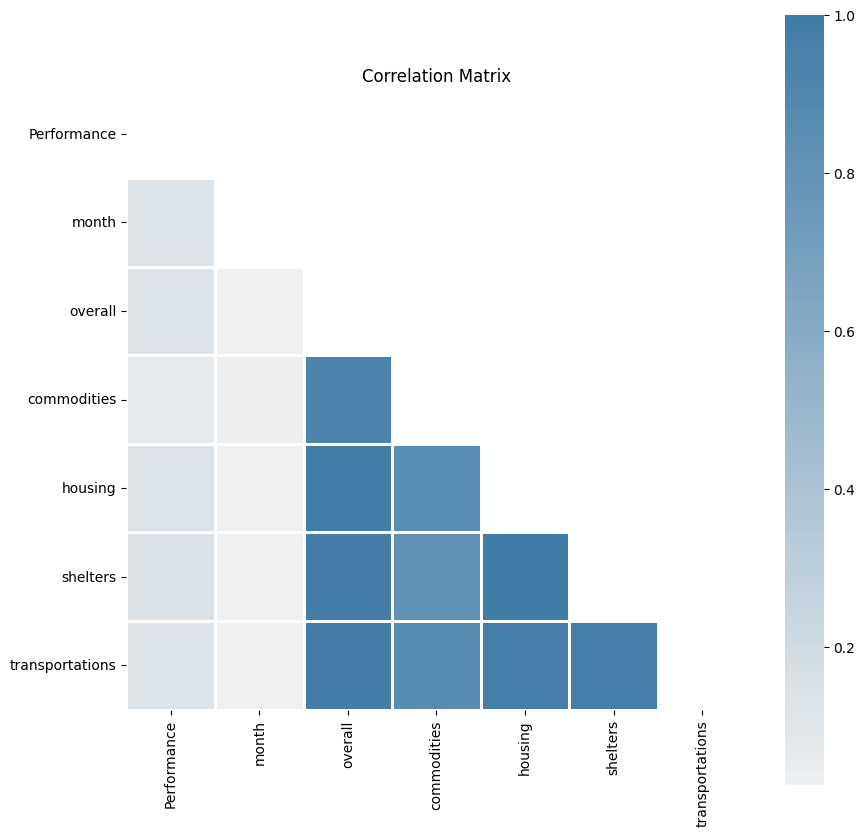

In [8]:
dd.correlation_matrix(original)

### Conditional GAN

In [9]:
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Real Estate (Sector),S&P 500 Performance (%),S&P 500 Real Estate (Sector) Performance (%),overall,commodities,housing,shelters,transportations,dow
0,9,3467.455240,172.326053,-12.842091,-5.392142,239.179306,185.492347,245.002058,302.729275,308.213165,3
1,11,1231.385768,106.890774,-0.530761,-2.698274,237.309972,180.733663,219.521073,265.728250,263.547830,3
2,10,3885.876701,223.223704,-6.459868,-3.282269,263.009341,184.235234,265.422385,315.422538,293.045420,3
3,7,1453.733317,173.166050,-12.380497,-7.735111,240.148273,183.750404,224.071376,277.306787,275.658368,3
4,8,1373.896573,132.530769,23.248122,7.270437,196.905419,163.739558,197.245101,215.952334,227.244620,3
...,...,...,...,...,...,...,...,...,...,...,...
9995,4,938.557553,122.587930,-5.344209,-10.604277,188.330582,161.394111,220.500963,231.892111,223.875143,3
9996,9,1159.036456,141.961346,4.896390,11.489809,183.185127,143.065190,187.747204,191.063986,198.237934,3
9997,9,2577.209959,218.982321,-0.669949,1.619155,246.951967,186.669652,243.980095,311.919020,304.161203,3
9998,9,1432.347470,211.726208,38.346091,-0.498085,259.073034,190.182876,236.719929,282.609450,304.261224,3


In [10]:
samples['Performance'] = np.where(samples['S&P 500 Real Estate (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)

In [11]:
samples = samples[['Performance','month','overall','commodities','housing','shelters','transportations']]
samples.head()

,Performance,month,overall,commodities,housing,shelters,transportations
0,1,9,239.179306,185.492347,245.002058,302.729275,308.213165
1,0,11,237.309972,180.733663,219.521073,265.728250,263.547830
2,1,10,263.009341,184.235234,265.422385,315.422538,293.045420
3,1,7,240.148273,183.750404,224.071376,277.306787,275.658368
4,0,8,196.905419,163.739558,197.245101,215.952334,227.244620


In [12]:
dd.data_summary(samples)

,Info
Rows,10000
Columns,7
Size in Memory,547.0 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,1,1,0.59,0.49,2,5856
month,int64,0,0,1,7,12,6.55,3.46,12,903
overall,float64,0,0,159.76,230.27,287.96,225.45,25.071,10000,1
commodities,float64,0,0,129.86,182.12,232.30,177.71,13.87,10000,1
housing,float64,0,0,169.65,223.33,308.43,227.31,29.040,10000,1
shelters,float64,0,0,172.91,248.93,338.97,256.37,36.95,10000,1
transportations,float64,0,0,185.69,270.50,353.40,262.99,36.16,9998,2


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

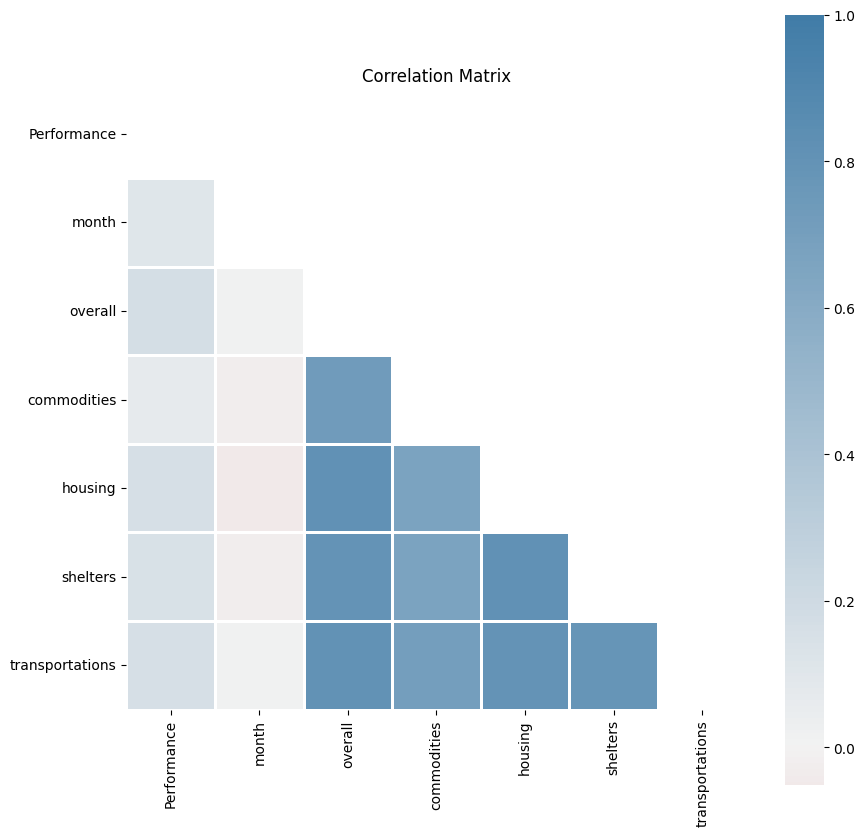

In [13]:
dd.correlation_matrix(samples)

In [14]:
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']

### SMOTE Oversampling

In [15]:
counter = Counter(y)
print(counter)
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
counter = Counter(y)
print(counter)

Counter({1: 5856, 0: 4144})
Counter({1: 5856, 0: 5856})


### Interaction Terms

In [16]:
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
X_poly

array([[  239.17930619,   185.49234651,   245.00205757, ...,
        74169.29528471, 75512.85963865, 93305.14806957],
       [  237.30997178,   180.73366251,   219.52107339, ...,
        58332.95056031, 57854.30263294, 70032.10364975],
       [  263.00934079,   184.23523374,   265.4223853 , ...,
        83720.20231794, 77780.81440191, 92433.13005231],
       ...,
       [  238.25401228,   173.66910495,   218.78755685, ...,
        57001.16988899, 59512.60287574, 70867.55951694],
       [  245.25403001,   188.17855505,   224.58232147, ...,
        59021.69710743, 66593.51670721, 77927.81682337],
       [  197.00218763,   165.17439148,   197.09504536, ...,
        43391.31958464, 43507.15948854, 48597.30363877]])

In [17]:
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X.shape

(11712, 16)

In [18]:
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
X_real.shape

(234, 16)

In [19]:
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)

### Training with CV

In [20]:
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.66479,0.680667,0.625684,0.651563,0.655738,0.65727,0.618715,0.63741,0.606838,0.569106,0.642202,0.603448
1,DecisionTreeClassifier,0.638746,0.649382,0.610128,0.628272,0.637637,0.632405,0.618715,0.625485,0.529915,0.495726,0.53211,0.513274
2,RandomForestClassifier,0.721229,0.742449,0.689539,0.713283,0.699112,0.700655,0.671788,0.685918,0.594017,0.558333,0.614679,0.585153
3,AdaBoostClassifier,0.65975,0.65832,0.664786,0.661453,0.652322,0.640434,0.659218,0.64969,0.653846,0.618644,0.669725,0.643172
4,GradientBoostingClassifier,0.674095,0.681019,0.655223,0.667772,0.665984,0.658298,0.659218,0.658758,0.649573,0.621622,0.633028,0.627273
5,ExtraTreesClassifier,0.730364,0.754433,0.701318,0.723916,0.713456,0.707198,0.706704,0.706951,0.606838,0.569106,0.642202,0.603448
6,BaggingClassifier,0.684001,0.719921,0.609616,0.659006,0.675205,0.693795,0.601257,0.64422,0.598291,0.571429,0.550459,0.560748
7,SVC,0.639687,0.640661,0.636438,0.638471,0.639344,0.633523,0.622905,0.628169,0.602564,0.570175,0.59633,0.58296
8,GaussianNB,0.603057,0.595175,0.644633,0.618858,0.597336,0.57961,0.643156,0.609732,0.576923,0.539683,0.623853,0.578723


### Voting Classifier

In [21]:
et_clf = ExtraTreesClassifier(random_state=random_state)
bag_clf = BaggingClassifier(random_state=random_state)
rf_clf = RandomForestClassifier(random_state=random_state)
classifiers = [('RF', rf_clf), \
               ('ET', et_clf),\
              ('Bagging', bag_clf)]

vc = VotingClassifier(estimators = classifiers, voting = 'soft')     
vc.fit(x_train, y_train)
y_pred = vc.predict(x_test)
vc_res = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F-1 Score'])
vc_res.loc[0, 'Accuracy'] = accuracy_score(y_test, y_pred)
vc_res.loc[0, 'Precision'] = precision_score(y_test, y_pred)
vc_res.loc[0, 'Recall'] = recall_score(y_test, y_pred)
vc_res.loc[0, 'F-1 Score'] = f1_score(y_test, y_pred)
vc_res

,Accuracy,Precision,Recall,F-1 Score
0,0.702869,0.70245,0.680866,0.691489


## Using data after 2010 (Best Model)

In [22]:
data = pd.read_csv('../data/S&P 500 Real Estate 100-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data = data[data['year'] >= 2010]
data

,year,month,date,S&P 500,S&P 500 Real Estate (Sector),S&P 500 Performance (%),S&P 500 Real Estate (Sector) Performance (%),S&P 500 Real Estate (Sector) Outperform/Underperform,overall,commodities,housing,shelters,transportations,dow
95,2010,1,2010-01-14,1148.46,94.040001,8.787618,-5.468438,UNDERPERFORM,217.281,174.321,216.042,247.997,257.050,3
96,2010,2,2010-02-11,1078.47,86.949997,1.716544,-12.498748,UNDERPERFORM,217.353,174.137,216.146,247.914,257.804,3
97,2010,3,2010-03-11,1150.24,99.019997,2.657837,-11.312140,UNDERPERFORM,217.403,173.874,216.092,247.959,258.306,3
98,2010,4,2010-04-08,1186.44,105.040001,13.110628,-1.758321,UNDERPERFORM,217.290,173.367,216.128,248.128,258.969,3
99,2010,5,2010-05-13,1157.44,109.879997,-0.285160,-4.227321,UNDERPERFORM,217.199,172.929,216.060,248.295,259.454,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,2021,7,2021-07-08,4320.82,283.359985,-7.184331,-6.277704,OUTPERFORM,273.092,201.975,281.979,335.888,326.470,3
230,2021,8,2021-08-12,4460.83,290.109985,-6.940799,-9.453811,UNDERPERFORM,274.214,203.215,283.532,337.298,323.329,3
231,2021,9,2021-09-09,4493.28,296.170013,-1.171440,0.454508,OUTPERFORM,276.590,206.035,285.453,338.865,323.995,3
232,2021,10,2021-10-14,4438.26,288.570007,3.749053,0.076297,UNDERPERFORM,278.524,208.467,286.849,340.475,326.256,3


In [23]:
original = data[['S&P 500 Real Estate (Sector) Outperform/Underperform','month','overall','commodities','housing','shelters','transportations']]
data.drop(columns=['date','S&P 500 Real Estate (Sector) Outperform/Underperform','year'], inplace=True)
original['Performance'] = np.where(original['S&P 500 Real Estate (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','commodities','housing','shelters','transportations']]
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Real Estate (Sector),S&P 500 Performance (%),S&P 500 Real Estate (Sector) Performance (%),overall,commodities,housing,shelters,transportations,dow
0,6,1306.421749,129.770011,1.890028,1.245028,223.369669,181.553606,218.850536,250.764893,259.132257,3
1,6,1397.630363,109.802209,5.920604,-1.636985,220.791039,183.567672,216.820787,240.053603,267.425071,3
2,7,1759.937353,158.590664,-10.207272,-9.663091,235.959629,189.075629,237.166392,257.072702,284.573163,3
3,10,1553.683299,144.244502,-12.058056,-10.074796,234.249983,184.589073,227.143748,263.221595,271.532819,3
4,4,2252.812154,246.642240,-12.147498,-7.986880,253.877756,184.303507,225.394511,312.284127,295.405590,3
...,...,...,...,...,...,...,...,...,...,...,...
9995,5,1776.292082,135.878220,-8.975965,-2.368554,238.093119,187.851761,235.146140,264.172633,274.186111,3
9996,5,1257.950028,249.490351,-5.517923,-6.213499,254.423802,185.506471,226.136568,271.414934,277.771821,3
9997,12,4546.696682,245.112123,-8.289447,-10.996633,274.642336,186.542239,277.214305,341.238736,341.069409,3
9998,9,2972.334692,236.762098,-13.792690,-0.006696,253.244441,183.244729,257.516657,301.926153,306.119021,3


In [24]:
samples['Performance'] = np.where(samples['S&P 500 Real Estate (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)
samples = samples[['Performance','month','overall','commodities','housing','shelters','transportations']]
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.710947,0.757007,0.627959,0.685247,0.688757,0.727016,0.606848,0.661519,0.546763,0.546512,0.661972,0.598726
1,DecisionTreeClassifier,0.693639,0.711662,0.65932,0.683591,0.671302,0.690647,0.623377,0.65529,0.589928,0.597222,0.605634,0.601399
2,RandomForestClassifier,0.781435,0.811481,0.742899,0.773779,0.759763,0.785992,0.715466,0.749073,0.546763,0.543478,0.704225,0.613497
3,AdaBoostClassifier,0.670562,0.661966,0.697485,0.679147,0.669231,0.665708,0.682999,0.674242,0.532374,0.53125,0.71831,0.610778
4,GradientBoostingClassifier,0.683654,0.678442,0.699408,0.688593,0.690828,0.696073,0.680047,0.687967,0.568345,0.56044,0.71831,0.62963
5,ExtraTreesClassifier,0.807027,0.839019,0.770562,0.801253,0.777515,0.803871,0.735537,0.768187,0.568345,0.551402,0.830986,0.662921
6,BaggingClassifier,0.734837,0.785903,0.65074,0.711007,0.70355,0.754038,0.606257,0.67212,0.539568,0.546667,0.577465,0.561644
7,SVC,0.656287,0.644177,0.699112,0.670384,0.658876,0.657726,0.66588,0.661778,0.597122,0.588235,0.704225,0.641026
8,GaussianNB,0.570858,0.550147,0.778107,0.644541,0.568343,0.549391,0.771547,0.641787,0.57554,0.556604,0.830986,0.666667
